# drosophila_simulation_extension_disorder

> copy of notebook `04_drosophila_simulation`, measure tissue extension with disordered initial condition

A more systematic approach is taken in notebook 09b.

In [ ]:
#| default_exp disorder

In [ ]:
#| export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso
import CE_simulation.drosophila as drs

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
#| export

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection, PatchCollection

from scipy import optimize, ndimage

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
#| export

from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
#| export

import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [ ]:
#| export

from collections import Counter

In [ ]:
#| notest

import importlib

In [ ]:
## reloading the modules in case you edit them

importlib.reload(msh); importlib.reload(tns); importlib.reload(dln); importlib.reload(iso); importlib.reload(drs)

<module 'CE_simulation.drosophila' from '/home/nikolas/Documents/UCSB/streichan/numerics/code/python code/jupyter notebooks/GBE simulation/disordered simulation/CE_simulation/CE_simulation/drosophila.py'>

## Initial condition creation with random delaunay



In [ ]:
#| export

# use the scipy quasi monte carlo sampler to generate samples of hard disk point process.
# then Delaunay that, and shear to get initial condition

from scipy.stats import qmc
from scipy import spatial

In [ ]:
help(qmc.PoissonDisk)

Help on class PoissonDisk in module scipy.stats._qmc:

class PoissonDisk(QMCEngine)
 |  PoissonDisk(d: 'IntNumber', *, radius: 'DecimalNumber' = 0.05, hypersphere: "Literal['volume', 'surface']" = 'volume', ncandidates: 'IntNumber' = 30, optimization: "Optional[Literal['random-cd', 'lloyd']]" = None, seed: 'SeedType' = None) -> 'None'
 |  
 |  Poisson disk sampling.
 |  
 |  Parameters
 |  ----------
 |  d : int
 |      Dimension of the parameter space.
 |  radius : float
 |      Minimal distance to keep between points when sampling new candidates.
 |  hypersphere : {"volume", "surface"}, optional
 |      Sampling strategy to generate potential candidates to be added in the
 |      final sample. Default is "volume".
 |  
 |      * ``volume``: original Bridson algorithm as described in [1]_.
 |        New candidates are sampled *within* the hypersphere.
 |      * ``surface``: only sample the surface of the hypersphere.
 |  ncandidates : int
 |      Number of candidates to sample per ite

In [ ]:
radius = .043 # need to tune this to get tightly packed 
ncandidates = 2000  # determines density. high values = slow.

engine = qmc.PoissonDisk(d=2, radius=radius, hypersphere='volume', ncandidates=ncandidates,
                         optimization=None, seed=1)

In [ ]:
sample = engine.random(400)  # can't really fit that many in there anyways
engine.reset()
#sample = engine.fill_space()

# method: random (sample), fill_space()

print("n samples:", sample.shape[0])

n samples: 400


In [ ]:
sample.shape[0] * np.pi * (radius/2)**2 

0.5808804816487527

In [ ]:
#| export

# we want to auto-tune the radius to get the desired number of candidates.
# assume a random packing fraction of like 75% (https://doi.org/10.1103/PhysRevA.41.4199)
# in truth, the qmd algorithm spits out lower densities, like 60%. and we also need to remove boundary pts
# aspect ratio correction if we want to select a rectangle etc ou of the square

def hard_disk_radius(desired_samples, aspect=1, density=.55):
    return 2*np.sqrt((density/aspect)/(desired_samples*np.pi))

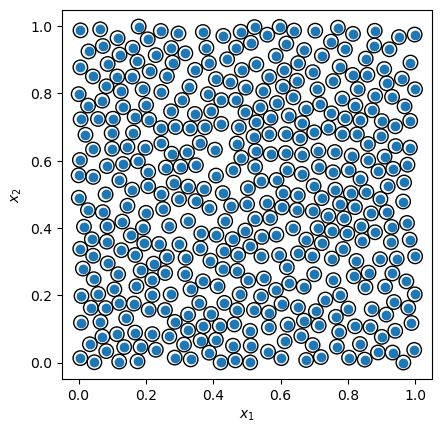

In [ ]:
fig, ax = plt.subplots()

_ = ax.scatter(sample[:, 0], sample[:, 1])

circles = [plt.Circle((xi, yi), radius=radius/2, fill=False) for xi, yi in sample]
collection = PatchCollection(circles, match_original=True)
ax.add_collection(collection)

_ = ax.set(aspect='equal', xlabel=r'$x_1$', ylabel=r'$x_2$') #, xlim=[0, 1], ylim=[0, 1])

plt.show()

In [ ]:
#| export

@patch
def get_edge_lens(self: msh.Face):
    vs = [v.coords for v in self.vertices]
    ls = np.array([np.linalg.norm(vs[0]-vs[1]),
                   np.linalg.norm(vs[1]-vs[2]),
                   np.linalg.norm(vs[2]-vs[0])])
    return ls

@patch
def remove_obtuse_bdry(self: msh.HalfEdgeMesh, iterations=2, min_obtuse=1):
    """
    Remove all boundary triangles from mesh iteratively
    
    We often like to remove boundary triangles when creating a mesh from a Delaunay triangulation
    on some point set. The original Delaunay boundary edges will be very long. Unfortunately I have
    only implemented this for pre-meshes..., hence the wrapper.
    
    Can filter and remove only edges with very long sides (longest side min_obtuse times longer than shortest).
    """
    premesh = self.to_ListOfVerticesAndFaces()
    mesh_new = deepcopy(self)
    for i in range(0, iterations):
        remove = [key for key, fc in mesh_new.faces.items() if fc.is_bdry_edge()
                  and (np.max(fc.get_edge_lens())/np.min(fc.get_edge_lens())) > min_obtuse]
        for key in remove:
            premesh.remove_face(key)
        mesh_new = msh.HalfEdgeMesh(premesh)
        
    return mesh_new

In [ ]:
# now delaunay

pts = sample
tri = spatial.Delaunay(pts)
premesh = msh.ListOfVerticesAndFaces(tri.points, tri.simplices)
mesh = msh.HalfEdgeMesh(premesh)

# we would like to remove all the original Delaunay boundary edges which will be very long
mesh = mesh.remove_obtuse_bdry(iterations=6, min_obtuse=2)
mesh.set_voronoi()

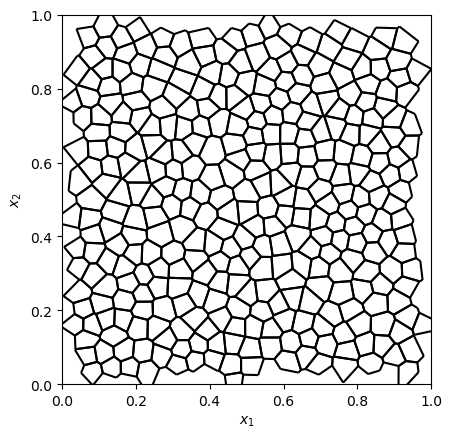

In [ ]:
#mesh.triplot()
mesh.cellplot()

_ = plt.gca().set(aspect='equal', xlabel=r'$x_1$', ylabel=r'$x_2$', xlim=[0, 1], ylim=[0, 1])

In [ ]:
#| export

def rect_mask(x, aspect=1):
    """Aspect > 1 corresponds to tall rectangles"""
    min_y, max_y = (0, 1)
    dx = 1- 1/aspect
    min_x, max_x = (dx/2, 1-dx/2)
    return (min_y <= x[1] <= max_y) and (min_x <= x[0] <= max_x)

In [ ]:
# it would be nice to change the aspect ratio, get different shapes than a square
# tried modify the `random` method of the PoissonDisk class to change the acceptance region
# via monkey-patching. But this is complicated, because the neighbor lookup (is new sample overlapping with
# another sample depends on the sample being in the unit square. So the easiest thing to do
# is to sample the square and the select a sub-region (e.g. circle)



aspect = 1.5
rect_sample = np.stack([x for x in sample if rect_mask(x, aspect=aspect)])

pts = rect_sample
tri = spatial.Delaunay(pts)
premesh = msh.ListOfVerticesAndFaces(tri.points, tri.simplices)
mesh = msh.HalfEdgeMesh(premesh)

# we would like to remove all the original Delaunay boundary edges which will be very long
mesh = mesh.remove_obtuse_bdry(iterations=6, min_obtuse=2)
mesh.set_voronoi()

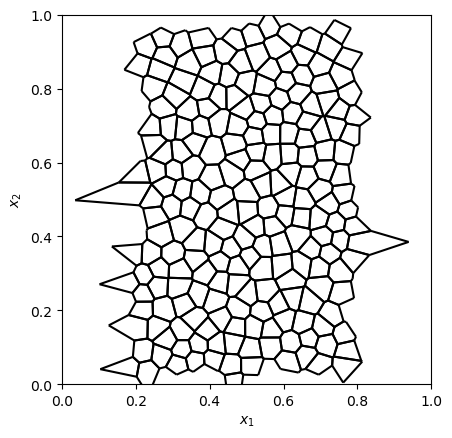

In [ ]:
#mesh.triplot()
mesh.cellplot()

_ = plt.gca().set(aspect='equal', xlabel=r'$x_1$', ylabel=r'$x_2$', xlim=[0, 1], ylim=[0, 1])

In [ ]:
# now rescale, so that edges have length one on average, and do a slight shear of tension triangulation
# this might lead to Voronoi self-intersection

shear = 1.1

rescale = 1/np.mean(list(mesh.get_edge_lens().values()))
mesh.transform_vertices(lambda x: x*rescale)
mesh.transform_vertices(dln.shear_mat(shear))
mean = np.mean([v.coords for v in mesh.vertices.values()], axis=0)
mesh.transform_vertices(lambda x: x-mean)

mesh.set_voronoi()

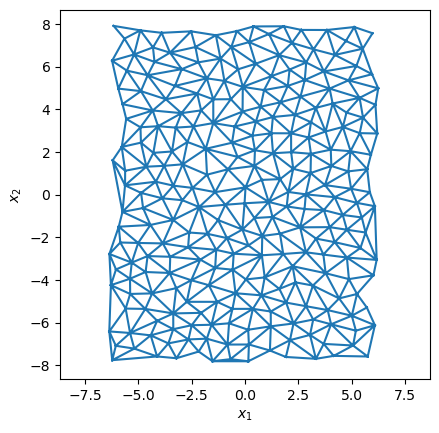

In [ ]:
#mesh.cellplot()
mesh.triplot()

_ = plt.gca().set(aspect='equal', xlabel=r'$x_1$', ylabel=r'$x_2$',
                  xlim=[-rescale/2, rescale/2], ylim=[-rescale/2, rescale/2])

In [ ]:
# now we also need to designate active and passive cells etc. make everything at the edge passive

passive_faces = sorted([fc._fid for fc in mesh.faces.values() if fc.is_bdry()])
passive_edges = list(msh.flatten([[he._heid for he in mesh.faces[fc].hes] for fc in passive_faces]))
passive_cells = [v._vid for v in mesh.vertices.values()
                 if not v.is_bdry() and any([fc._fid in passive_faces for fc in v.faces])]

property_dict = {"passive_faces": passive_faces, "passive_edges": passive_edges, "passive_cells": passive_cells,
                 "bdry_x": np.max([v.coords[0] for v in mesh.vertices.values()])+1,
                 "bdry_y": np.max([v.coords[1] for v in mesh.vertices.values()])+1}

In [ ]:
#| export

# package this into a function


def create_poisson_disk_initial(n_vertices, aspect=1, initial_strain=0.1, isogonal=0, random_seed=1):
    """
    Create (rectangular shaped) Poisson hard disk Voronoi mesh.
    
    Sample points from a hard disk Poisson distribution using scipy quasi-monte carlo module.
    Use it to create a mesh using Delauny. There are a bunch of post-processing steps(select rectangle with
    desired aspect ratio, remove long boundary edges, set active/passive regions, shear).
    
    Can take a bit of time to sample since we want the disks closely packed and the algorithm is naive.
    
    Note: no boundaries.
    
    Parameter
    ---------
    n_vertices: int
        Approximate number of desired vertices. Not guaranteed to match exactly
    initial_strain: float
        Initial y-axis strain applied to tension triangulation. Applies transform matrix
        diag(1/(1+s), 1+s)
    isogonal : float
        isogonal mode, incorporated into reference shape tensors. 0 = isotropic, >0 y-axis elongated
    random_seed: int
        Numpy random number generator seed.
    
    Returns
    -------
    mesh: iso.CellHalfEdgeMesh
    
    property_dict: dict
        dictionary with bounding box size and active/passive cells/edges in the patch
    
    """
    # sample points
    aspect = aspect * (1+initial_strain)/(1-initial_strain) # adjust aspect for shear
    radius = hard_disk_radius(n_vertices, aspect=aspect)
    ncandidates = 4*n_vertices  # determines density. high values = slow.
    engine = qmc.PoissonDisk(d=2, radius=radius, hypersphere='volume', ncandidates=ncandidates,
                             optimization=None, seed=random_seed)
    sample = engine.random(int(n_vertices*aspect))  
    rect_sample = np.stack([x for x in sample if rect_mask(x, aspect=aspect)])

    # use Delaunay to create mesh
    tri = spatial.Delaunay(rect_sample)
    premesh = msh.ListOfVerticesAndFaces(tri.points, tri.simplices)
    mesh = msh.HalfEdgeMesh(premesh)
    # remove all the original Delaunay boundary edges which will be very long
    mesh = mesh.remove_obtuse_bdry(iterations=6, min_obtuse=2)
    
    # rescale, and shear
    rescale = 1/np.mean(list(mesh.get_edge_lens().values()))
    mesh.transform_vertices(rescale*dln.shear_mat(1+initial_strain))
    mean = np.mean([v.coords for v in mesh.vertices.values()], axis=0)
    mesh.transform_vertices(lambda x: x-mean)

    # transform to cell mesh and set initial edge lengths and primal coords
    mesh = iso.CellHalfEdgeMesh(mesh)
    mesh.set_rest_lengths()
    mesh.set_voronoi()
    
    # set active and passive faces
    passive_faces = sorted([fc._fid for fc in mesh.faces.values() if fc.is_bdry()])
    passive_edges = list(msh.flatten([[he._heid for he in mesh.faces[fc].hes] for fc in passive_faces]))
    passive_cells = [v._vid for v in mesh.vertices.values()
                     if not v.is_bdry() and any([fc._fid in passive_faces for fc in v.faces])]

    property_dict = {"passive_faces": passive_faces, "passive_edges": passive_edges, "passive_cells": passive_cells,
                     "bdry_x": np.max([v.coords[0] for v in mesh.vertices.values()])+1,
                     "bdry_y": np.max([v.coords[1] for v in mesh.vertices.values()])+1}
    
    # set isogonal mode .
    for v in mesh.vertices.values():
        if v._vid in passive_cells:
            v.rest_shape = np.sqrt(3) * np.array([[1, 0],[0, 1]])
        else:
            v.rest_shape = np.sqrt(3) * np.array([[1-isogonal, 0],[0, 1+isogonal]])

    return mesh, property_dict

## Simulation with boundary conditions and passive & active cells

[<matplotlib.lines.Line2D>]

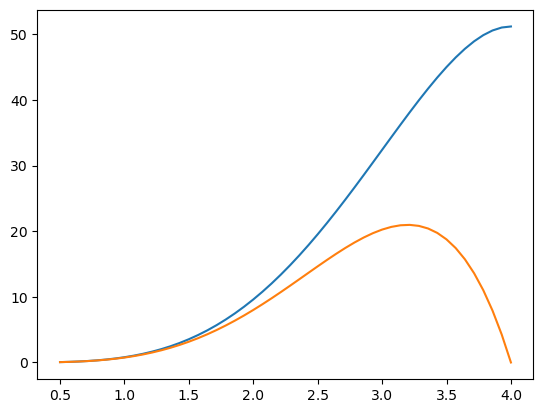

In [ ]:
Ts = np.linspace(0.5, 4)

k_cutoff = 0.3
m = 4


fig = plt.figure()

plt.plot(Ts, Ts**m - 0.2*Ts**(m+1))

plt.plot(Ts, Ts**m - 0.25*Ts**(m+1))


### Plot initial condition

In [ ]:
np.max(list(mesh_ordered.get_edge_lens().values()))

1.4793924312817426

In [ ]:
# create initial condition

mesh_ordered, property_dict_ordered = drs.create_rect_initial(34, 40, noise=0.1, initial_strain=0.1,
                                                              orientation='orthogonal', isogonal=0,
                                                              boundaries=None,
                                                              w_passive=0, w_passive_lr=0, random_seed=3)

In [ ]:
# set colors for edges and cells

cell_alpha = .5

edge_colors_ordered = {key: "tab:grey" for key in property_dict_ordered['passive_edges']}
cell_colors_active_ordered = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
                              for key in mesh_ordered.vertices.keys()
                              if not key in property_dict_ordered['passive_cells']}

(-19.5, 19.5)

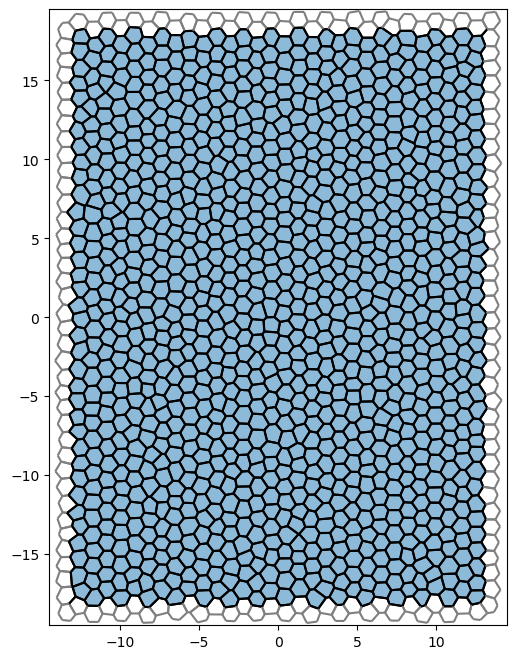

In [ ]:
fig = plt.figure(figsize=(8,8))

mesh_ordered.cellplot(edge_colors=edge_colors_ordered,
                      cell_colors=cell_colors_active_ordered)
#mesh_initial.triplot(): 
#mesh_initial.labelplot()

plt.gca().set_aspect("equal", adjustable="box");
#plt.xticks([],[])
#plt.yticks([],[])
plt.xlim([-property_dict_ordered["bdry_x"]-.5, property_dict_ordered["bdry_x"]+.5])
plt.ylim([-property_dict_ordered["bdry_y"]-.5, property_dict_ordered["bdry_y"]+.5])

#plt.axis("off")

In [ ]:
ordered_centroids = np.stack([v.get_centroid() for v in mesh_ordered.vertices.values()])
delta_ordered = np.quantile(ordered_centroids, axis=0, q=.9)-np.quantile(ordered_centroids, axis=0, q=.1,)

print("aspect ratios")
print(delta_ordered[1] / delta_ordered[0])
# original simulation 36*48 had 1.53

aspect ratios
1.3532054791512869


In [ ]:
mesh_disordered, property_dict_disordered = create_poisson_disk_initial(len(mesh_ordered.vertices),
                                                                        initial_strain=0, aspect=1.45,
                                                                        isogonal=0, random_seed=11)


edge_colors_disordered = {key: "tab:grey" for key in property_dict_disordered['passive_edges']}
cell_colors_active_disordered = {key: mpl.colors.to_rgba('tab:blue') * np.array([1,1,1,.5])
                                 for key in mesh_disordered.vertices.keys()
                                 if not key in property_dict_disordered['passive_cells']}

In [ ]:
ordered_centroids = np.stack([v.get_centroid() for v in mesh_ordered.vertices.values()])
delta_ordered = np.quantile(ordered_centroids, axis=0, q=.9)-np.quantile(ordered_centroids, axis=0, q=.1,)

print("aspect ratios")
print(delta_ordered[1] / delta_ordered[0])

disordered_centroids = np.stack([v.get_centroid() for v in mesh_disordered.vertices.values()])
delta_disordered = np.quantile(disordered_centroids, axis=0, q=.9)-np.quantile(disordered_centroids, axis=0, q=.1,)

print(delta_disordered[1] / delta_disordered[0])


print('n vertices')
print(len(mesh_ordered.vertices))
print(len(mesh_disordered.vertices))

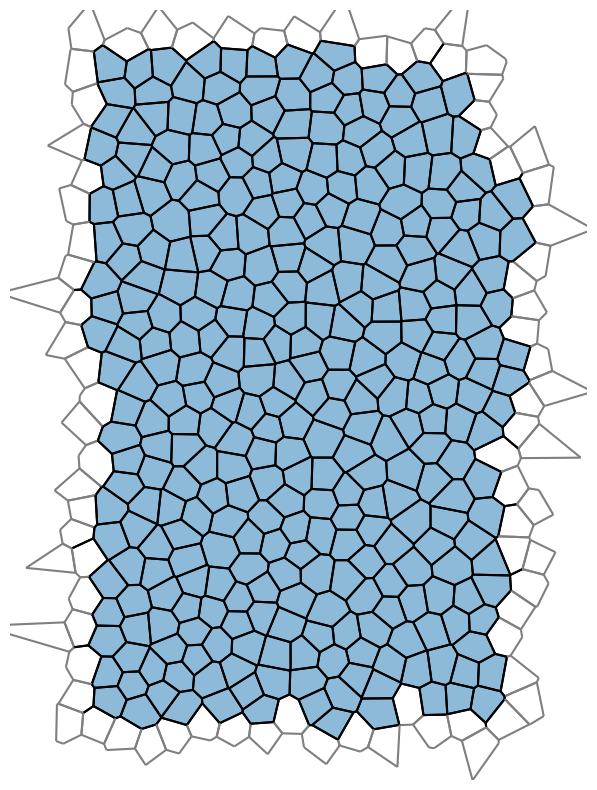

In [ ]:
fig = plt.figure(figsize=(8,8))

mesh_disordered.cellplot(edge_colors=edge_colors_disordered,
                      cell_colors=cell_colors_active_disordered)
#mesh_initial.triplot(): 
#mesh_initial.labelplot()


plt.gca().set_aspect("equal", adjustable="box");
#plt.xticks([],[])
#plt.yticks([],[])
plt.xlim([-property_dict_ordered["bdry_x"]-1, property_dict_ordered["bdry_x"]+1])
plt.ylim([-property_dict_ordered["bdry_y"]-1, property_dict_ordered["bdry_y"]+1])
plt.axis("off")
plt.tight_layout()
#plt.savefig("plots/SI figs and movies/disordered_initial.pdf")


In [ ]:
valence = Counter([len(v.incident) for v in mesh_disordered.vertices.values() if not v.is_bdry()])

keys = [4, 5, 6, 7, 8]
valence = {key: valence[key]/sum(valence.values()) for key in keys}

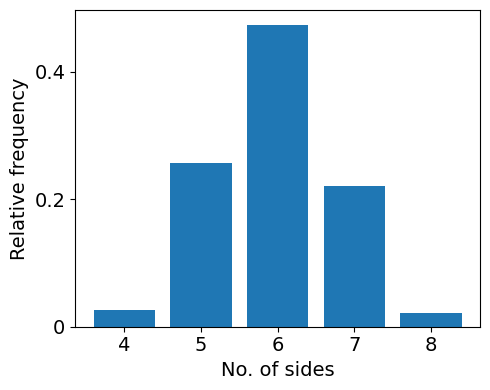

In [ ]:
fig = plt.figure(figsize=(5,4))

plt.bar(keys, [valence[key] for key in keys])
plt.xlabel('No. of sides', fontsize=14)
plt.ylabel('Relative frequency', fontsize=14)
plt.xticks(keys, keys, fontsize=14)
plt.yticks([0, .2, .4], [0, .2, .4], fontsize=14)

plt.tight_layout()

#plt.savefig("plots/SI figs and movies/disordered_initial_hist.pdf")


### Simulation with cable feedback

In [ ]:
#| export

def cable_dt_act_pass(Ts, Tps, m, k=1, T_minus=0, T_c=1, T_plus=1.25):
    """
    Time derivative of tension for making cables. m used to mark passive cells (m == 1)
    """
    dT_dt = (m!=1)*(-(Ts-T_minus)*(Ts-T_c)*(Ts-T_plus)) - k*(m==1)*(Ts-1)
    dT_dt -= dT_dt.mean()
    dTp_dt = -k*Tps
    return dT_dt, dTp_dt

## set simulation parameters

In [ ]:
passive_ids = property_dict_ordered['passive_faces']  # need to set this correctly!
passive_cells = property_dict_ordered['passive_cells']

In [ ]:
## feedback parameters

m = 4
k = .5
k_cutoff = .2 # regularization term to cut off excitable feedbacl

def params_pattern(fid):
    if fid in passive_ids:
        return {"k": k, "m": 1} # tension relaxation rate in passive region
    return {"k": k, "m": 4, "k_cutoff": k_cutoff}

def params_pattern_cable(fid):
    if fid in passive_ids:
        return {"k": k, "m": 1, "T_minus": 0, "T_c": 1, "T_plus": 1.25}  # T_plus: 1.25
    return {"k": k, "m": 2, "T_minus": 0, "T_c": 1, "T_plus": 1.25}


dt = 0.05 # time step 0.005
n_steps = 150 # just a short simulation for testing purposes
forbid_reflip = 20 # numerical constant - forbid a re-flip on an edge that just collapsed for some time steps
                   # (because the edge is still very short, albeit extending, it would be detected as intercalating)
                   # More systematic treatment would check if a short junction is extending/contracting to determine
                   # whether it needs to be flipped.

minimal_l = .075 # minimal edge length, lower edge lengths trigger T1

tri_mod_area = .01 # triangle area regularization

In [ ]:
## cell shape parameters

tol, maxiter = (1e-4, 500000)  #1e-4
mod_bulk = 1
mod_shear = .5 # .5
angle_penalty = 1000
bdry_penalty = 5000

epsilon_l = (1e-3, 1e-4)  # mollifying parameters to ensure energy differentiability

A0 = jnp.sqrt(3)/2
mod_area = 0
P0 = 2*jnp.sqrt(3)/2
mod_perimeter = 0

bdr_weight = 4 # 2

rel_elastic_modulus = .8 # reduction in elastic modulus in passive cells
cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

use_voronoi = False # don't do shape optimization, run voronoi instead

In [ ]:
# package all into a single dict to pass to the optimizer method

energy_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear,
               "angle_penalty": angle_penalty, "bdry_penalty": bdry_penalty, "epsilon_l": epsilon_l,
               "A0": A0, "mod_area": mod_area, "P0": P0, "mod_perimeter": mod_perimeter}
optimizer_args = {'energy_args': energy_args, 'cell_id_to_modulus': cell_id_to_modulus,
                  'tol': tol, 'maxiter': maxiter, 'verbose': True, 'bdr_weight': bdr_weight}

In [ ]:
## rest length relaxation

k_rest = 1

def rhs_rest_shape(v):
    """Rest shape relaxation but do not relax area, i.e. trace. Also, only relax passive cells"""
    if v._vid in passive_cells:
        delta = v.rest_shape-v.get_shape_tensor()
        return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    else:
        return 0
    ## other option: just relax to isotropic
    #delta = v.rest_shape-v.get_shape_tensor()
    #return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))


## Simulation loop

Note: when saving, we need to save some additional data (the passive tensions and the cell rest shapes) which are not by default saved by the `HalfEdgeMesh` save routine. They are saved as dicts, so that after loading the properties can be set again, for example to continue simulating.

In [ ]:
mesh_initial = deepcopy(mesh_ordered)

In [ ]:
meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

In [ ]:
save = False
save_dir = "runs/poisson_disk_control_cable_feedback"
if save:
    try:
        os.mkdir(save_dir)
    except FileExistsError:
        print('Warning: directory exists')
    drs.save_self(save_dir, fname="09_disorder_extension_simulation.ipynb")
    with open(f'{save_dir}/property_dicy.pickle', 'wb') as handle:
        pickle.dump(property_dict_ordered, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [ ]:
## simulation loop

mesh = deepcopy(meshes[-1])
for i in tqdm(range(len(meshes)-1, n_steps)):
    # euler step
    #mesh.euler_step(dt=dt, rhs_tension=tns.excitable_dt_act_pass, params=params_pattern,
    #                rhs_rest_shape=rhs_rest_shape)
    mesh.euler_step(dt=dt, rhs_tension=cable_dt_act_pass, params=params_pattern_cable,
                    rhs_rest_shape=rhs_rest_shape)

    # flatten triangulation
    mesh.flatten_triangulation(mod_area=tri_mod_area, tol=1e-4)
    # primal optimization
    if use_voronoi:
        mesh.set_voronoi()
    else:
        mesh.optimize_cell_shape(**optimizer_args)
    # check for intercalation
    flipped, failed_flip = mesh.intercalate(exclude=list(msh.flatten(last_flipped_edges[-forbid_reflip:])),
                                            minimal_l=minimal_l, reoptimize=False, optimizer_args=optimizer_args)
    if failed_flip:
        print(f"tpt {i}: flip {flipped}, failed {failed_flip}")
    if flipped and not failed_flip:
        print(f"tpt {i}: flip {flipped}")
    # rescale & reorient triangulation
    mesh.transform_vertices(dln.get_conformal_transform(meshes[-1], mesh))
    # log & save
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)
    if save:
        mesh.save_mesh(f"{save_dir}/{str(i).zfill(4)}_mesh", save_attribs=True)
last_flipped_edges.append([])

  0%|          | 0/150 [00:00<?, ?it/s]

tpt 19: flip [198]
tpt 20: flip [597]
tpt 31: flip [384]
tpt 40: flip [198]
tpt 41: flip [597]
tpt 49: flip [453]
tpt 52: flip [384, 891]
tpt 58: flip [750]
tpt 61: flip [198]
tpt 62: flip [597, 142]
tpt 66: flip [969, 960, 507]
tpt 67: flip [684]
tpt 70: flip [453]
tpt 73: flip [384, 891, 393]
tpt 82: flip [198]
tpt 84: flip [897]
tpt 87: flip [969, 960, 702, 768]
tpt 88: flip [684, 690]
tpt 89: flip [21]
tpt 91: flip [453, 663]
tpt 92: flip [126]
tpt 93: flip [561]
tpt 94: flip [891, 393, 384, 621]
tpt 95: flip [606, 270]
tpt 96: flip [936]
tpt 97: flip [783]
tpt 98: flip [711]
tpt 103: flip [198]
tpt 104: flip [642]
tpt 108: flip [768, 969, 960, 276]
tpt 109: flip [684]
tpt 113: flip [126]
tpt 115: flip [384, 393, 621, 891]
tpt 116: flip [270]
tpt 117: flip [936]
tpt 119: flip [711, 876]
tpt 123: flip [738]
tpt 125: flip [642]
tpt 129: flip [276, 960, 768, 969]
tpt 130: flip [684]
tpt 131: flip [693]
tpt 132: flip [375, 585]
tpt 134: flip [126]
tpt 136: flip [891, 621, 927]
tpt 137:

In [ ]:
# just for convenience, save ids of T1s at each time. The T1s at each timepoint can also be reconstructed
# from the meshes if necessary.

last_flipped_edges.append([]) 
if save:
    with open(f'{save_dir}/last_flipped_edges.pickle', 'wb') as handle:
        pickle.dump(last_flipped_edges, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [ ]:
meshes[-1].is_consistent()

True

### Loading a saved simulation

In [ ]:
## reload a mesh. need to load rest shapes and passive tensions from separate pickle files
# only load a subsample of meshes, which is helpful when dealing with large meshes which can overwhelm memory

load_dir = 'runs/poisson_disk_control_v0'
meshes_control = [iso.CellHalfEdgeMesh.load_mesh(f'{load_dir}/{str(i).zfill(4)}_mesh')
                  for i in tqdm(range(0, 300, 1))]

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
load_dir = 'runs/poisson_disk_v1'
meshes_disordered = [iso.CellHalfEdgeMesh.load_mesh(f'{load_dir}/{str(i).zfill(4)}_mesh')
                     for i in tqdm(range(0, 300, 1))]

  0%|          | 0/300 [00:00<?, ?it/s]

# Analysis

Shows several types of plots

In [ ]:
## junction collapse for time alignment


In [ ]:
flipped = [[key for key in meshes_control[t].hes.keys() 
            if [v._vid for v in meshes_control[t].hes[key].vertices] != [v._vid for v in meshes_control[t+1].hes[key].vertices]]
            for t in range(0, len(meshes_control)-1)] + []

NameError: name 'meshes_control' is not defined

In [ ]:
# collect all junction lengths
length_dicts = [x.get_primal_edge_lens() for x in tqdm(meshes_control)]

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:

# align on T1 transitions using the saved ids of T1s during simulation.

lengths_stacked = []

dt  = 90

for i in range(150, 200):
    for e in flipped[i]:
        if not e in property_dict_ordered['passive_edges']:
            try:
                length = np.stack([x[e] for x in length_dicts])
                lengths_stacked.append(length[i-dt:i+dt])
            except KeyError:
                continue
            
lengths_stacked = np.stack(lengths_stacked)

In [ ]:
lengths_stacked.shape

(21, 180)

[[<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>],
 [<matplotlib.lines.Line2D>]]

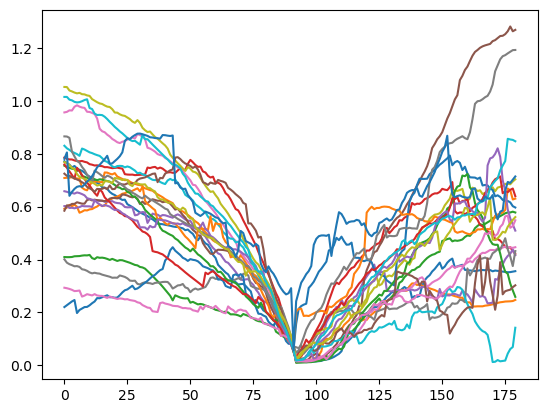

In [ ]:
[plt.plot(x) for x in lengths_stacked]

<matplotlib.legend.Legend>

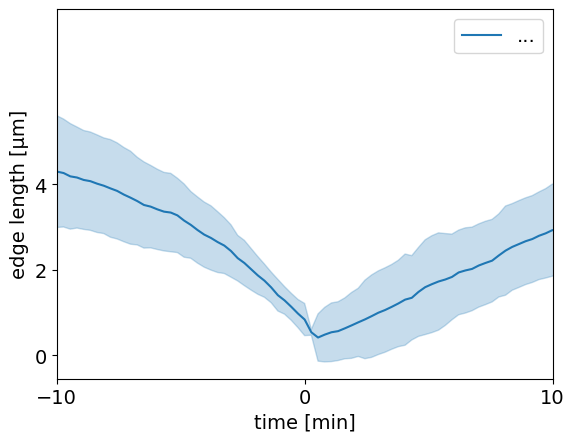

In [ ]:
time = .27*(np.arange(lengths_stacked.shape[1]) - dt)  #.28

length_scale = 8.5  # 8.5

mean = (lengths_stacked.mean(axis=0)) * length_scale
std = lengths_stacked.std(axis=0) * length_scale

plt.plot(time, mean, color='tab:blue', label=r'...')
plt.fill_between(time, mean-std, mean+std, color='tab:blue', alpha=.25)

plt.xlim([-10, 10])
plt.xticks([-10, 0, 10], fontsize=14)
plt.yticks([0, 2, 4], fontsize=14)


plt.xlabel('time [min]', fontsize=14)
plt.ylabel('edge length [μm]', fontsize=14)
plt.legend(fontsize=14)

### Slider plots

Most importantly, visualize the mesh interactively

<IPython.core.display.Javascript object>


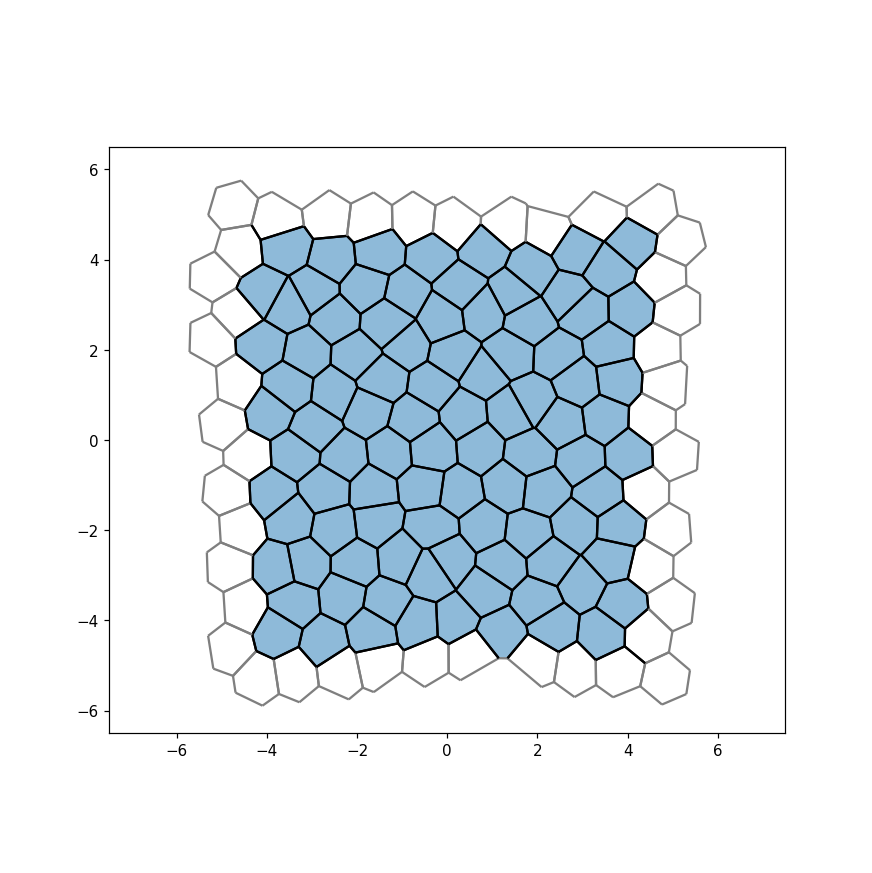

interactive(children=(IntSlider(value=75, description='i', max=150), FloatSlider(value=7.5, description='xlim'…

In [ ]:
#| notest

%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
    
# fix the arguments which you do not need to tune with widgets.fixed

#bdry_x, bdry_y = (property_dict_disordered["bdry_x"], property_dict_disordered["bdry_y"])

bdry_x, bdry_y = (property_dict_ordered["bdry_x"], property_dict_ordered["bdry_y"])


widgets.interact(drs.plot_mesh, i=(0, len(meshes)-1, 1), xlim=(bdry_x, 2*bdry_x),
                 ylim=widgets.fixed(bdry_y+.5), slipwall_y=widgets.fixed(None),
                 edge_colors=widgets.fixed(edge_colors_ordered),
                 cell_colors=widgets.fixed(cell_colors_active_ordered),
                 mesh_series=widgets.fixed(meshes),
                 #flipped_series=widgets.fixed(None),
                 flipped_series=widgets.fixed(last_flipped_edges)
                );


# extension to 4- -4 with cables

In [ ]:
%matplotlib inline

### Measure the amount of tissue extension

In [ ]:
#| export

def get_tissue_extension(meshes, sigma=2, q=0.9, log=True, exclude=None):
    """Get tissue extension by means of q% x- and y-axis bounding box"""
    exclude = [] if exclude is None else exclude
    centroids = np.stack([[v.get_centroid() for key, v in mesh.vertices.items()
                           if (not v.is_bdry()) and (not v._vid in exclude)
                          ] for mesh in meshes[1:]])

    delta = np.quantile(centroids, axis=1, q=q)-np.quantile(centroids, axis=1, q=1-q,)
    delta_smooth = ndimage.gaussian_filter1d(delta, axis=0, sigma=sigma)[sigma:-sigma]
    delta_smooth /= delta_smooth[0]
    if log:
        delta_log = np.log(delta_smooth)
        return delta_log
    return delta_smooth

In [ ]:
delta_perimeter = get_tissue_extension(meshes_perimter)
time = np.arange(delta_perimeter.shape[0])*4*15/100

In [ ]:
delta_area = get_tissue_extension(meshes[:190])
time_area = np.arange(delta_area.shape[0])*4*15/100

In [ ]:
%matplotlib inline

Text(0, 0.5, 'x-fold change')

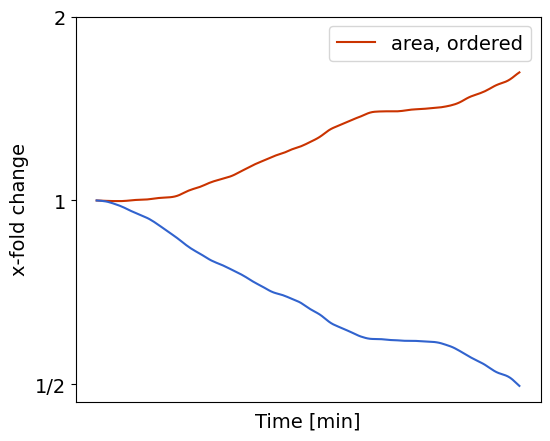

In [ ]:
fig = plt.figure(figsize=(6, 5))


plt.plot(time_area, delta_area[:,0], color='#ca3300ff', label="area, ordered")
plt.plot(time_area, delta_area[:,1], color='#3163ceff')


plt.yticks([np.log(1/2), 0, np.log(2)], ["1/2", 1, "2"], fontsize=14);

plt.xticks([],[])

plt.legend(fontsize=14)

plt.xlabel('Time [min]',fontsize=14)
plt.ylabel('x-fold change', fontsize=14)


In [ ]:
np.exp(delta_perimeter[-1]) # 50% extension, 40% retraction

array([1.52489161, 0.58666394])

Text(0, 0.5, 'x-fold change')

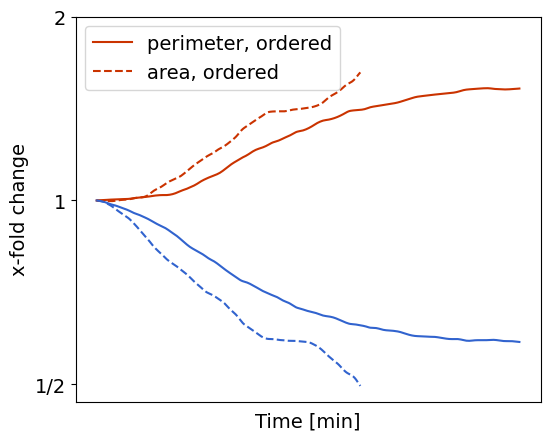

In [ ]:
fig = plt.figure(figsize=(6, 5))


plt.plot(time, delta_perimeter[:,0], color='#ca3300ff', label="perimeter, ordered")
plt.plot(time, delta_perimeter[:,1], color='#3163ceff')


plt.plot(time_area, delta_area[:,0], color='#ca3300ff', ls="--", label="area, ordered")
plt.plot(time_area, delta_area[:,1], color='#3163ceff', ls="--")


plt.yticks([np.log(1/2), 0, np.log(2)], ["1/2", 1, "2"], fontsize=14);

plt.xticks([],[])

plt.legend(fontsize=14)

plt.xlabel('Time [min]',fontsize=14)
plt.ylabel('x-fold change', fontsize=14)

# area simulation ran into numerical issues but was clearly expaning faster. 

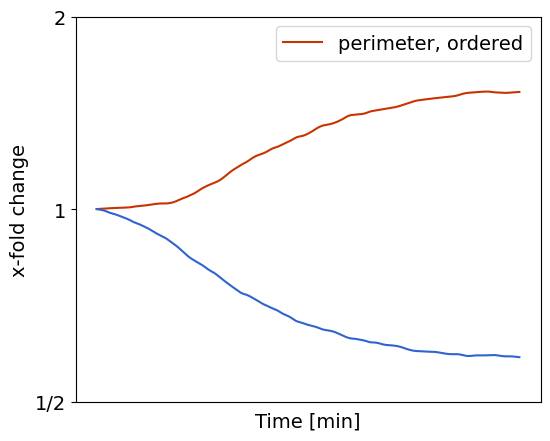

Goal:

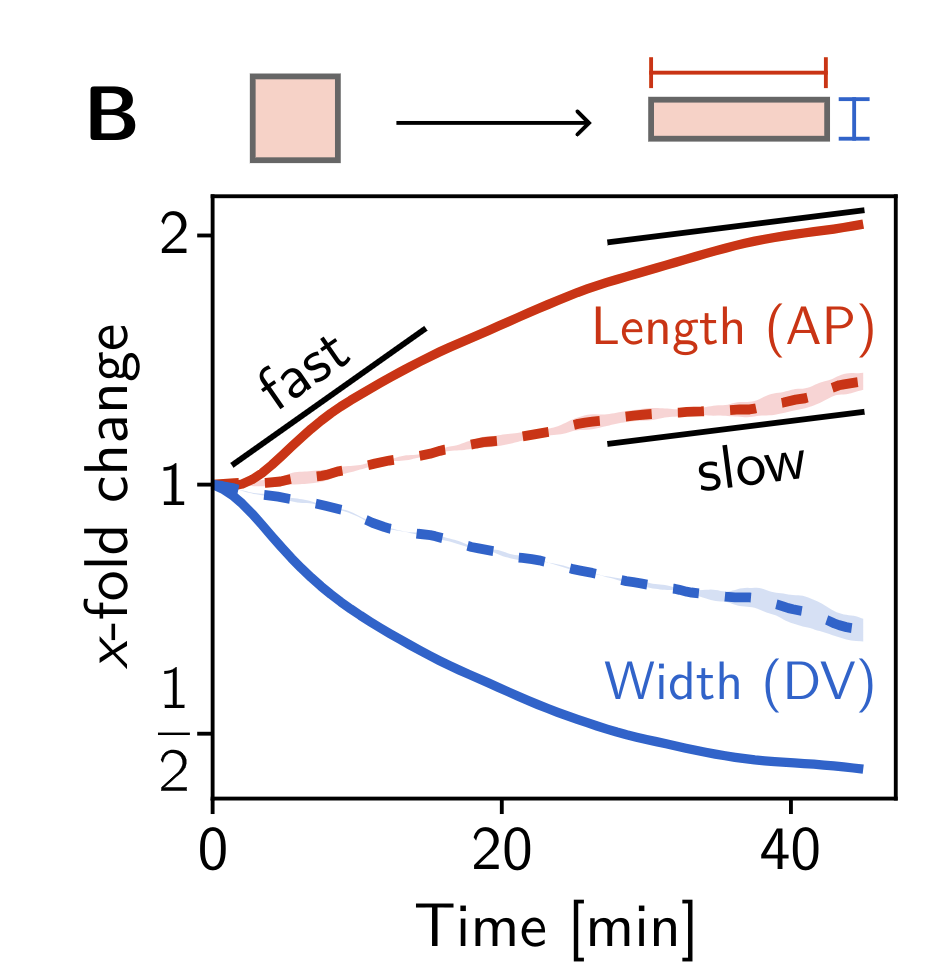

In [ ]:
# overlay initial and final positions of active cell vertices

centroids = np.stack([[v.get_centroid() for key, v in mesh.vertices.items()
                       if key not in passive_cells and not v.is_bdry()] for mesh in meshes_disordered[1:]])

centroids_control = np.stack([[v.get_centroid() for key, v in mesh.vertices.items()
                               if key not in passive_cells and not v.is_bdry()] for mesh in meshes_control[1:]])



plt.scatter(*centroids[2].T, label='intial cell centroids')
plt.scatter(*centroids[-1].T, label='final cell centroids')
plt.legend(loc=(.1, 1.02))

plt.gca().set_aspect("equal", adjustable="box")

NameError: name 'meshes_disordered' is not defined

In [ ]:
# compute width and height. could also use the inertia tensors of the centroid cloud, or any other number of things

sigma = 5

t_final = -1

delta = np.quantile(centroids, axis=1, q=.9)-np.quantile(centroids, axis=1, q=.1,)
delta_smooth = ndimage.gaussian_filter1d(delta, axis=0, sigma=sigma)[sigma:-sigma][:t_final]
delta_smooth /= delta_smooth[0]
delta_log = np.log(delta_smooth)

delta_control = np.quantile(centroids_control, axis=1, q=.9)-np.quantile(centroids_control, axis=1, q=.1,)
delta_control_smooth = ndimage.gaussian_filter1d(delta_control, axis=0, sigma=sigma)[sigma:-sigma][:t_final]
delta_control_smooth /= delta_control_smooth[0]
delta_control_log = np.log(delta_control_smooth)

In [ ]:
print("control",  delta_control_smooth[-1][0]/delta_control_smooth[-1][1])
print("disorder", delta_smooth[-1][0]/delta_smooth[-1][1])

control 3.859918904811044
disorder 1.8920475318912853


In [ ]:
3.859918904811044 / 1.8920475318912853

2.0400750191263324

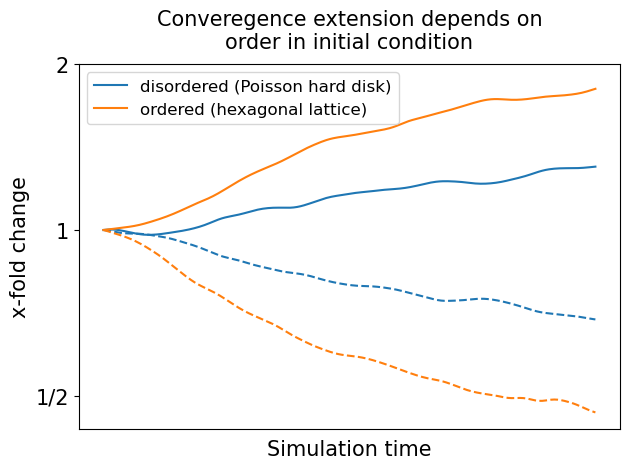

In [ ]:
# plot width and height

time = np.arange(delta_smooth.shape[0])

plt.plot(time, delta_log[:,0], label='disordered (Poisson hard disk)', color='tab:blue')
plt.plot(time, delta_log[:,1], color='tab:blue', ls="--")

time = np.arange(delta_control_smooth.shape[0])
plt.plot(time, delta_control_log[:,0], label='ordered (hexagonal lattice)', color='tab:orange', )
plt.plot(time, delta_control_log[:,1], color='tab:orange', ls="--")

plt.title("Converegence extension depends on\norder in initial condition", fontsize=15, y=1.02)

plt.yticks([-np.log(2), 0, np.log(2)], ["1/2", 1, "2"], fontsize=15);
plt.xticks([])

plt.xlabel('Simulation time', fontsize=15)
plt.ylabel('x-fold change', fontsize=15)
plt.legend(fontsize=12)

plt.tight_layout()

#plt.savefig("plots/SI figs and movies/extension_disorder.pdf")

In [ ]:
dt = 0.005 # time step
n_steps = 300

In [ ]:
n_steps * dt

1.5

In [ ]:
200 * 15/100

30.0